In [1]:
import warnings
from capymoa.classifier import HoeffdingAdaptiveTree, HoeffdingTree
from capymoa.evaluation import (
    ClassificationEvaluator, 
    prequential_evaluation, 
    ClassificationWindowedEvaluator
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.drift.detectors import DDM, ADWIN

warnings.filterwarnings('ignore')

# Gerando fluxos de dados sintéticos 

* `SEA Drift`: é um gerador de fluxo de dados sintético que simula um cenário de drifts abruptos e recorrentes. Ele não modifica um fluxo existente, mas cria um novo onde a regra de decisão fundamental (o conceito) muda instantaneamente em intervalos de tempo pré-definidos. O fluxo alterna entre diferentes funções pré-estabelecidas, forçando um modelo a se readaptar completamente a uma nova "realidade" de dados várias vezes ao longo do fluxo.
    * `SEA(function= int 1)`: Verificar se são todos os números inteiros (Acho que não). 
* `AbruptDrift`: é um wrapper que induz uma única mudança de conceito abrupta e instantânea ao combinar dois fluxos de dados distintos. Ele opera gerando amostras de um fluxo inicial (Conceito A) até um ponto específico e, imediatamente após esse ponto, descarta o primeiro fluxo e passa a gerar amostras exclusivamente do segundo fluxo (Conceito B), simulando uma substituição completa e imediata do conceito.
    * `AbruptDrift(position=5000)`
* `GradualDrift`: é um wrapper que simula uma transição suave e prolongada entre dois conceitos (Conceito A e Conceito B) ao longo de uma janela de tempo definida. Em vez de uma troca instantânea, ele inicia uma fase de transição onde amostras de ambos os fluxos coexistem. Durante essa janela, a probabilidade de amostras do Conceito A aparecerem diminui gradualmente, enquanto a probabilidade de amostras do Conceito B aumenta, até que o fluxo seja composto inteiramente pelo Conceito B.
    * `GradualDrift(position=10000, width=2000)`
    * `GradualDrift(start=9000, end=12000)`

Nos exemplos abaixo é utilizando o RandomTreeGenerator (RTG). Este é um gerador excelente para criar fluxo de dados que é complexo, não-linear, mas estável. No entanto, existe uma variedade de outros geradores no capyMOA, o RTG é o seu campo de provas genérico. Os outros são para simular cenários de "desgraça" específicos e ver se o seu algoritmo aguenta o tranco.

https://capymoa.org/api/modules/capymoa.stream.generator.html

## Dicionário com fluxos sintéticos

### Explicação

- ``"RTG"`` (RandomTreeGenerator) Primeiro, o gerador constrói uma única árvore de decisão aleatória e a mantém fixa, usando parâmetros como max_tree_depth e num_attributes. Para gerar cada nova instância, ele sorteia valores aleatórios para os atributos (numéricos e nominais) e "percorre" essa árvore fixa com esses valores; a classe da instância é determinada pela folha da árvore em que ela "cai".

- ``"RTG_drift"`` (DriftStream com RandomTreeGenerator) Este gerador usa o DriftStream para alternar entre diferentes árvores de decisão (definidas por diferentes tree_random_seed). Ele começa usando a árvore 1; na posição 1000, ocorre um drift abrupto, e o gerador passa a usar instantaneamente a árvore 2. Na posição 3000, inicia-se um drift gradual de 500 instâncias, onde a stream transiciona suavemente da árvore 2 para a árvore 3 (durante essa janela, instâncias podem ser geradas por ambas as árvores, seguindo uma curva de probabilidade).

- ``"SEA"`` (SEA Generator) O gerador SEA cria instâncias (pontos) com 3 atributos numéricos relevantes (por padrão) e os classifica com base em sua posição relativa a um hiperplano de decisão fixo no espaço 3D (definido pela function=1). Pontos que caem de um lado do plano recebem a classe A, e os que caem do outro lado recebem a classe B (com alguma adição de ruído).

- ``"SEA_drift"`` (DriftStream com SEA) Similar ao "RTG_drift", este gerador muda o conceito (o hiperplano) ao longo do tempo. Ele começa usando o hiperplano da function=1; na posição 1000, ocorre um drift abrupto para a function=3 (um hiperplano diferente). Na posição 3000, inicia-se um drift gradual (largura de 500) que transiciona a stream de volta para a function=1.

- ``"RandomRBF"`` (RandomRBFGenerator) Este gerador primeiro espalha 50 "centróides" fixos (Funções de Base Radial) em um espaço de 10 atributos; cada centróide tem uma classe associada e um "raio" de influência. Para gerar uma nova instância, ele cria um ponto aleatório nesse espaço e o classifica com base no centróide mais próximo; a instância recebe a classe desse centróide.

- ``"RandomRBF_drift"`` (RandomRBFGeneratorDrift) Este gerador é projetado para simular drift movendo os centróides pelo espaço ao longo do tempo. No entanto, na sua configuração específica (magnitude_of_change=0.0), a magnitude da mudança é zero, fazendo com que os centróides permaneçam parados. Portanto, ele se comporta de maneira idêntica ao "RandomRBF", gerando uma stream estacionária.

In [6]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift, RecurrentConceptDriftStream
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=3000, width=500),
            RandomTreeGenerator(tree_random_seed=3),
        ]
    ),

    "SEA": SEA(function=1),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=1),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=2,
        magnitude_of_change=0.0,
    )
}

## Avaliando Streams Sintéticas

### Random Tree Generator (RTG) e SEA Generator

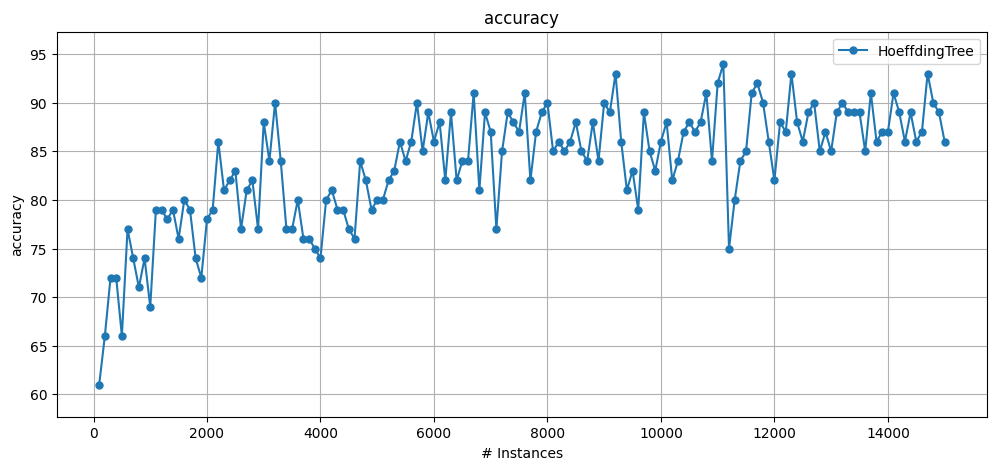

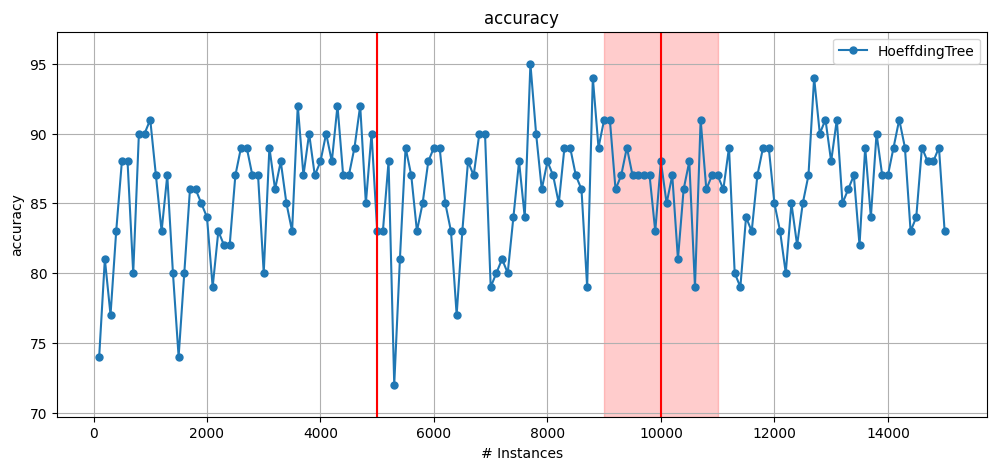

In [3]:
# Gerando um stream sem drift
RTG_stream = RandomTreeGenerator()

# Gerando um stream com drifts (SEA com drifts)
stream_sea2drift = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        # GradualDrift(start=9000, end=12000),
        SEA(function=1),
    ]
)

# Inicializando os classificadores Hoeffding Tree
HT = HoeffdingTree(schema=RTG_stream.get_schema())
HT_sea2drift = HoeffdingTree(schema=stream_sea2drift.get_schema())

# Avaliação prequential
results_HT = prequential_evaluation(
    max_instances=15000, 
    window_size=100, 
    stream=RTG_stream, 
    learner=HT
)

results_HT_sea2drift = prequential_evaluation(
    max_instances=15000, 
    window_size=100, 
    stream=stream_sea2drift, 
    learner=HT_sea2drift
)

# Visualização dos resultados
plot_windowed_results(results_HT, metric="accuracy")
plot_windowed_results(results_HT_sea2drift, metric="accuracy")

### Random Tree Generator (RTG) com Drifts

None
Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=5000),RTG(tree_random_seed=2),GradualDrift(position=20000, start=17500, end=22500, width=5000),RTG(tree_random_seed=3),AbruptDrift(position=50000),RTG(tree_random_seed=2),GradualDrift(position=65000, start=60000, end=70000, width=10000),RTG(tree_random_seed=3)
Recurrent concept stream MOA CLI: 
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 5000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 20000 -w 5000) -d (generators.RandomTreeGenerator -r 2) -p 50000 -w 0)  -d (generators.RandomTreeGenerator -r 3) -w 10000 -p 65000 -r 1 -a 0.0


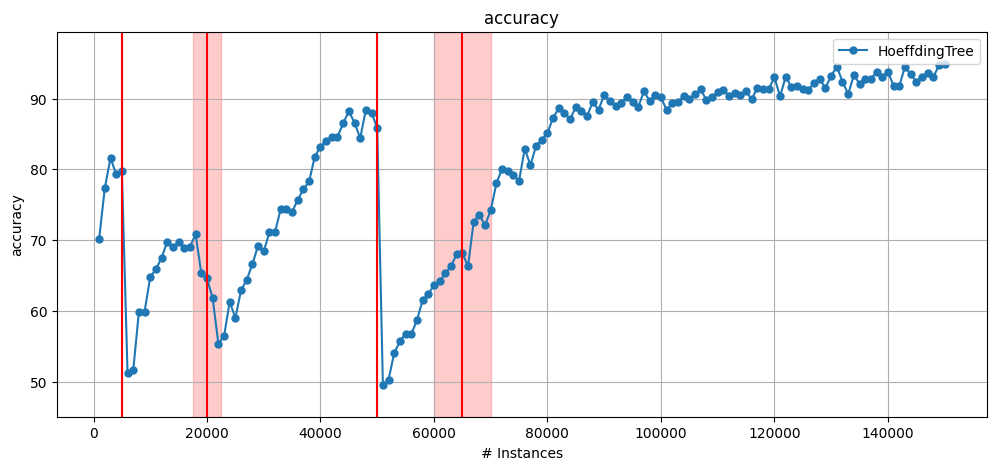

In [4]:
window_size = 1000
max_instances = 150000

stream_with_drifts = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=5000),
        RandomTreeGenerator(tree_random_seed=2),
        GradualDrift(position=20000, width=5000),
        RandomTreeGenerator(tree_random_seed=3),
        AbruptDrift(position=50000),
        RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1), # Faz reaparecer o conceito anterior
        GradualDrift(start=60000, end=70000),
        RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1), # Faz reaparecer o conceito anterior
    ]
)

HT = HoeffdingTree(schema=stream_with_drifts.get_schema())

results_stream_with_drifts = prequential_evaluation(
    stream=stream_with_drifts,
    learner=HT,
    window_size=window_size,
    max_instances=max_instances,
)

print(f"Recurrent concept stream CapyMOA:\n{stream_with_drifts}")
print(f"Recurrent concept stream MOA CLI: \n{stream_with_drifts._CLI}")
plot_windowed_results(results_stream_with_drifts, metric="accuracy")

### Random Tree Generator (RTG) Recorrente com Drifts

Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=10000),RTG(tree_random_seed=2),AbruptDrift(position=20000),RTG(tree_random_seed=3),AbruptDrift(position=30000),RTG(instance_random_seed=2),AbruptDrift(position=40000),RTG(instance_random_seed=2, tree_random_seed=2),AbruptDrift(position=50000),RTG(instance_random_seed=2, tree_random_seed=3)
Recurrent concept stream MOA CLI: 
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 10000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 20000 -w 0) -d (generators.RandomTreeGenerator -i 2) -p 30000 -w 0) -d (generators.RandomTreeGenerator -r 2 -i 2) -p 40000 -w 0)  -d (generators.RandomTreeGenerator -r 3 -i 2) -w 0 -p 50000 -r 1 -a 0.0


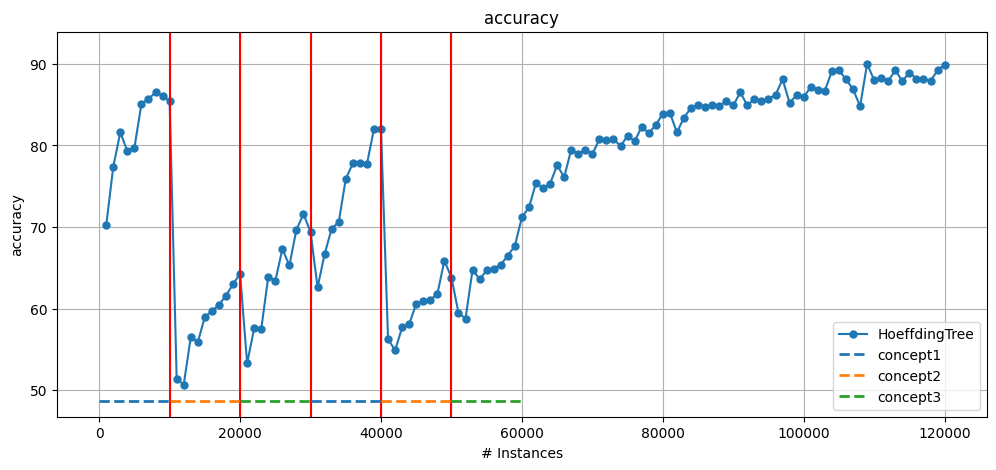

In [7]:
concept1 = RandomTreeGenerator(tree_random_seed=1, instance_random_seed=1)
concept2 = RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1)
concept3 = RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1)

window_size = 1000
concept_length = 10000
concept_list = [concept1, concept2, concept3]
concept_name_list = ["concept1", "concept2", "concept3"]
max_recurrences_per_concept = 2
max_instances = 120000

stream_with_recurrent_concepts = RecurrentConceptDriftStream(
    concept_list=concept_list,
    max_recurrences_per_concept=max_recurrences_per_concept,
    transition_type_template=AbruptDrift(position=concept_length),
    concept_name_list=concept_name_list,
)

HT = HoeffdingTree(schema=stream_with_recurrent_concepts.get_schema())

results_stream_with_drifts_HT = prequential_evaluation(
    stream=stream_with_recurrent_concepts,
    learner=HT,
    window_size=window_size,
    max_instances=max_instances,
)

print(f"Recurrent concept stream CapyMOA:\n{stream_with_recurrent_concepts}")
print(f"Recurrent concept stream MOA CLI: \n{stream_with_recurrent_concepts._CLI}")

plot_windowed_results(results_stream_with_drifts_HT, metric="accuracy")

# Identificando o Desvio de Conceito (Concept Drifts)

Alguns algoritmos identificam o desvio de conceito internamente, para identificar no fluxo foi inserirido um detector de drift externo, assim conseguirmos ter visão do desvio de conceito mesmo quando testamos em algoritmos com detectores internos.

- ``DDM()``
- ``ADWIN()``

In [8]:
window_size = 100
max_instances = 7000

stream = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=1000),
        RandomTreeGenerator(tree_random_seed=2),
        GradualDrift(position=5000, width=500),
        RandomTreeGenerator(tree_random_seed=3)
    ]
)

HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0,  # Padrão (0)
    grace_period=200,  # Padrão (200)
    split_criterion='InfoGainSplitCriterion',  # Padrão ('InfoGainSplitCriterion')
    confidence=0.01,  # Padrão (0.01)
    tie_threshold=0.05,  # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0,  # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver',  # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False,  # Padrão (False)
    max_byte_size=33554432,  # Padrão (32MB)
    memory_estimate_period=1000000,  # Padrão (1.000.000)
    stop_mem_management=True,  # Padrão (True)
    remove_poor_attrs=False,  # Padrão (False)
    disable_prepruning=True  # Padrão (True)
)

print(f"- Stream com drifts CapyMOA:\n     {stream}")
print(f"\n- Número de drifts no stream:\n     {stream.get_num_drifts()}")
print(f"\n- Stream schema:\n     {stream.get_schema()}")

- Stream com drifts CapyMOA:
     RTG(),AbruptDrift(position=1000),RTG(tree_random_seed=2),GradualDrift(position=5000, start=4750, end=5250, width=500),RTG(tree_random_seed=3)

- Número de drifts no stream:
     2

- Stream schema:
     @relation 'generators.RandomTreeGenerator '

@attribute nominal1 {value1,value2,value3,value4,value5}
@attribute nominal2 {value1,value2,value3,value4,value5}
@attribute nominal3 {value1,value2,value3,value4,value5}
@attribute nominal4 {value1,value2,value3,value4,value5}
@attribute nominal5 {value1,value2,value3,value4,value5}
@attribute numeric1 numeric
@attribute numeric2 numeric
@attribute numeric3 numeric
@attribute numeric4 numeric
@attribute numeric5 numeric
@attribute class {class1,class2}

@data


Desvio de conceito detectado pelo DDM na instância 1145!
Desvio de conceito detectado pelo ADWIN na instância 1151!
Desvio de conceito detectado pelo ADWIN na instância 1183!
Desvio de conceito detectado pelo ADWIN na instância 1215!
Desvio de conceito detectado pelo ADWIN na instância 5439!
Desvio de conceito detectado pelo DDM na instância 5584!
Desvio de conceito detectado pelo ADWIN na instância 5759!


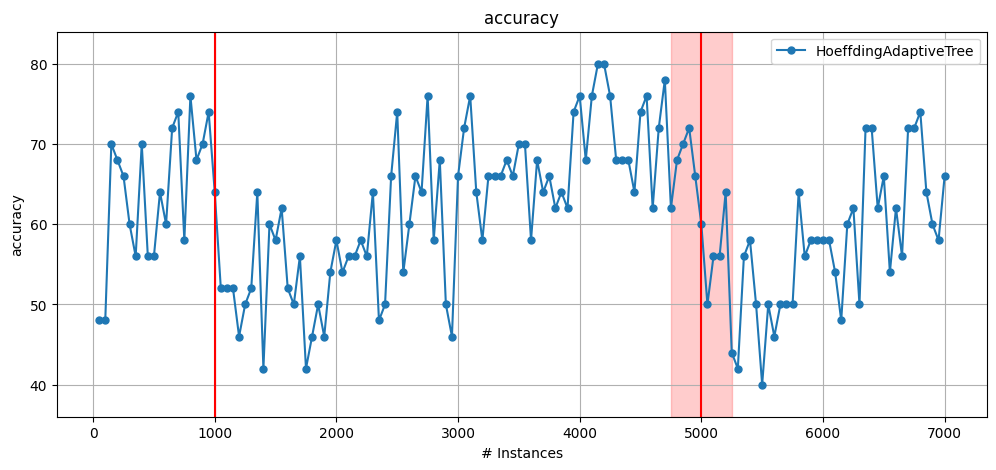

In [9]:
count = 0  
max_instances = 7000  

classificationEvaluatorHAT = ClassificationEvaluator(schema=stream.get_schema())
windowedEvaluatorHAT = ClassificationWindowedEvaluator(schema=stream.get_schema())

y_true_list = []
y_pred_list = []
DdmDetector = DDM(warning_level=2.0)
AdwinDetector = ADWIN()

stream.restart()
while stream.has_more_instances() and count < max_instances:  
    instance = stream.next_instance()
    prediction = HAT.predict(instance)

    y_true = instance.y_index
    error = 1.0 if prediction != y_true else 0.0
    DdmDetector.add_element(error)
    AdwinDetector.add_element(error)

    if DdmDetector.detected_change():
        print(f"Desvio de conceito detectado pelo DDM na instância {count}!")

    if AdwinDetector.detected_change():
        print(f"Desvio de conceito detectado pelo ADWIN na instância {count}!")

    HAT.train(instance)

    y_true_list.append(instance.y_index)
    y_pred_list.append(prediction)
    
    count += 1 
    print(f"Processadas {count} instâncias.", end='\r') 

stream.restart()
results = prequential_evaluation(
    stream=stream, 
    learner=HAT,
    window_size=50,
    max_instances=max_instances
)

plot_windowed_results(results, metric="accuracy")